## Beam deflection with double integration

In [16]:
%matplotlib widget 
# Documentation needed for ipyml - notifications on push from github
from bmcs_utils.api import InteractiveModel, IPWInteract
import traits.api as tr
import matplotlib.pylab as plt
from matplotlib.path import Path
import matplotlib.patches as mpatches
import numpy as np
import sympy as sp
from scipy.integrate import cumtrapz
sp.init_printing()

In [17]:
class BeamBC(tr.HasTraits):
    phi0_list = tr.List
    w0_list = tr.List
    
class BeamRC3Pt(BeamBC):
    pass

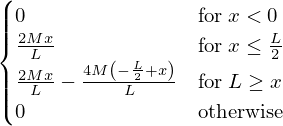

In [18]:
x, M, L, P= sp.symbols('x, M, L, P')
PtoM = {P : M*4/L}
# M_ = 2*M/L - 4*M/L*(x-L/2)
M_ = sp.Piecewise(
    (0,x<0),
    (2*M*x/L, x <= L/2),
    ((2*M*x/L - (4*M/L)*(x-L/2)), x<=L),
    (0, True)
            )
M_

In [19]:
get_M = sp.lambdify((x,M,L), M_)

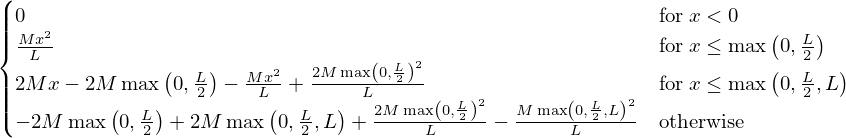

In [20]:
phi_ = sp.integrate(M_,(x))
phi_

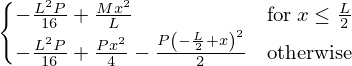

In [21]:
# phi_ = sp.integrate(M_,x)
phi_ = sp.Piecewise((M*x**2/L - P*L**2/16, x <= L/2),
    (P*x**2/4 - P*L**2/16 - P/2*(x-L/2)**2, x > L/2))
         
phi_

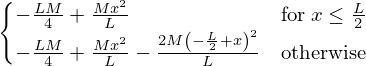

In [22]:
phi_ = phi_.subs(PtoM)
phi_

In [23]:
get_phi = sp.lambdify((x,M,L), phi_)

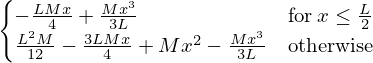

In [24]:
w_ = sp.integrate(phi_,x)
w_

In [25]:
get_w = sp.lambdify((x,M,L), w_)

In [26]:
from bmcs_beam.models.moment_curvature.moment_curvature import MomentCurvature


In [28]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

SyntaxError: invalid syntax (<ipython-input-28-37416827b12e>, line 3)

In [ ]:
class Beam3PtBending(InteractiveModel):
    '''
    Todo: 1- how to have tr.int
          2- divide it to more classes
          3- moving point load, line load, load combinations
    '''
    name = 'Inputs'
    
    mc_function = tr.Instance(MomentCurvature)
   
    # Reinforcement
    E_carbon = tr.Float(200000, param=True, latex='E_r [MPa]', minmax=(200000,300000)) 
    width = tr.Float(10, param=True, latex='rov_w [mm]', minmax=(10,450)) 
    thickness = tr.Float(1, param=True, latex='rov_t [mm]', minmax=(1,100))
    spacing = tr.Float(1, param=True, latex='ro_s [mm]', minmax=(1,100))
    n_layers = tr.Float(1, param=True, latex='n_l [-]', minmax=(1,100))
    A_roving = tr.Float(1, param=True, latex='A_r [mm2]', minmax=(1,100))
    
    #Concerte cross section
    L = tr.Float(5000, param=True, latex='L [mm]', minmax=(10,10000))
    H = tr.Float(10, param=True, latex='H [mm]', minmax=(10,500))
    B = tr.Float(10, param=True, latex='B [mm]', minmax=(10,500))
    E_con = tr.Float(14000, param=True, latex='E [MPa]', minmax=(14000,41000))
    F = tr.Float(10, param=True, latex='F [N]', minmax=(10,1000))
    n_x = tr.Float(100, param=True, latex='n_x', minmax=(1,1000))
    
    param_names = ['L', 'H', 'B', 'E_con' ,'F', 'E_carbon', 'width','thickness', 'spacing', 'n_layers', 'A_roving']
    
    x = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_x(self):
        return np.linspace(0,self.L,self.n_x)
    
    E_comp = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_E_comp(self):
        A_composite = self.B * self.H
        n_rovings = self.width / self.spacing 
        A_layer = n_rovings * self.A_roving 
        A_carbon = self.n_layers * A_layer 
        A_concrete = A_composite - A_carbon 
        E_comp = (self.E_carbon * A_carbon + self.E_con * A_concrete) / (A_composite)
        return E_comp   

    def get_M_x(self):
        M = self.F / 2 * self.L / 2
        M_x = get_M(self.x, M, self.L)
        return M_x
    
    def get_kappa_x(self):
        M = self.get_M_x()
#        I = (self.B*self.H**3)/12
        return mc.get_kappa(M)
#        return M / I / self.E_comp
    
    def get_phi_x(self):
        kappa_x = self.get_kappa_x()
        phi_x = cumtrapz(kappa_x, self.x, initial=0)
        phi_L2 = np.interp(self.L/2, self.x, phi_x)
        phi_x -= phi_L2
        return phi_x
    
    def get_w_x(self):
        phi_x = self.get_phi_x()
        w_x = cumtrapz(phi_x, self.x, initial=0)
        w_x += w_x[0]
        return w_x
    
    def subplots(self, fig):
        return fig.subplots(4, 1)

    def update_plot(self, axes):
        ax1, ax2, ax3, ax4 = axes
        
#         ax1.axis('equal');
        ax1.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
        ax1.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
        
        x = self.x
        
        M_x = self.get_M_x()
        ax2.plot(x, -M_x, color='red', label='moment [N.mm]')
        leg = ax2.legend();

        phi_x = self.get_phi_x()
        ax3.plot(x, phi_x, color='green', label='phi []')
        leg = ax3.legend();
        
        w_x = self.get_w_x()
        ax4.plot(x, w_x, color='blue', label='$w$ [mm]')
        leg = ax4.legend();

In [ ]:
bd = Beam3PtBending()

In [ ]:
bd = Beam3PtBending()
ibd = IPWInteract(bd)
ibd.interact()

In [ ]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [ ]:
class Beam3PtBending(InteractiveModel):
    '''
    Todo: 1- how to have tr.int
          2- divide it to more classes
          3- moving point load, line load, load combinations
    '''
    name = 'Inputs'
    
    mc_function = tr.Instance(MomentCurvature)
   
    # Reinforcement
    E_carbon = tr.Float(200000, param=True, latex='E_r [MPa]', minmax=(200000,300000)) 
    width = tr.Float(10, param=True, latex='rov_w [mm]', minmax=(10,450)) 
    thickness = tr.Float(1, param=True, latex='rov_t [mm]', minmax=(1,100))
    spacing = tr.Float(1, param=True, latex='ro_s [mm]', minmax=(1,100))
    n_layers = tr.Float(1, param=True, latex='n_l [-]', minmax=(1,100))
    A_roving = tr.Float(1, param=True, latex='A_r [mm2]', minmax=(1,100))
    
    #Concerte cross section
    L = tr.Float(5000, param=True, latex='L [mm]', minmax=(10,10000))
    H = tr.Float(10, param=True, latex='H [mm]', minmax=(10,500))
    B = tr.Float(10, param=True, latex='B [mm]', minmax=(10,500))
    E_con = tr.Float(14000, param=True, latex='E [MPa]', minmax=(14000,41000))
    F = tr.Float(10, param=True, latex='F [N]', minmax=(10,1000))
    n_x = tr.Float(100, param=True, latex='n_x', minmax=(1,1000))
    
    param_names = ['L', 'H', 'B', 'E_con' ,'F', 'E_carbon', 'width','thickness', 'spacing', 'n_layers', 'A_roving']
    
    x = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_x(self):
        return np.linspace(0,self.L,self.n_x)
    
    E_comp = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_E_comp(self):
        A_composite = self.B * self.H
        n_rovings = self.width / self.spacing 
        A_layer = n_rovings * self.A_roving 
        A_carbon = self.n_layers * A_layer 
        A_concrete = A_composite - A_carbon 
        E_comp = (self.E_carbon * A_carbon + self.E_con * A_concrete) / (A_composite)
        return E_comp   

    def get_M_x(self):
        M = self.F / 2 * self.L / 2
        M_x = get_M(self.x, M, self.L)
        return M_x
    
    def get_kappa_x(self):
        M = self.get_M_x()
#        I = (self.B*self.H**3)/12
        return mc.get_kappa(M)
#        return M / I / self.E_comp
    
    def get_phi_x(self):
        kappa_x = self.get_kappa_x()
        phi_x = cumtrapz(kappa_x, self.x, initial=0)
        phi_L2 = np.interp(self.L/2, self.x, phi_x)
        phi_x -= phi_L2
        return phi_x
    
    def get_w_x(self):
        phi_x = self.get_phi_x()
        w_x = cumtrapz(phi_x, self.x, initial=0)
        w_x += w_x[0]
        return w_x
    
    def subplots(self, fig):
        return fig.subplots(4, 1)

    def update_plot(self, axes):
        ax1, ax2, ax3, ax4 = axes
        
#         ax1.axis('equal');
        ax1.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
        ax1.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
        
        x = self.x
        
        M_x = self.get_M_x()
        ax2.plot(x, -M_x, color='red', label='moment [N.mm]')
        leg = ax2.legend();

        phi_x = self.get_phi_x()
        ax3.plot(x, phi_x, color='green', label='phi []')
        leg = ax3.legend();
        
        w_x = self.get_w_x()
        ax4.plot(x, w_x, color='blue', label='$w$ [mm]')
        leg = ax4.legend();

In [ ]:
bd = Beam3PtBending()

In [ ]:
bd = Beam3PtBending()
ibd = IPWInteract(bd)
ibd.interact()

In [ ]:
class section(InteractiveModel):

    name = 'section'
   
    # Reinforcement
    E_carbon = tr.Float(200000, param=True, latex='E_r [MPa]', minmax=(200000,300000)) 
    width = tr.Float(10, param=True, latex='rov_w [mm]', minmax=(10,450)) 
    thickness = tr.Float(1, param=True, latex='rov_t [mm]', minmax=(1,10))
    spacing = tr.Float(1, param=True, latex='ro_s [mm]', minmax=(1,100))
    n_layers = tr.Float(1, param=True, latex='n_l [-]', minmax=(1,10))
    A_roving = tr.Float(1, param=True, latex='A_r [mm2]', minmax=(1,100))
    
    #Concerte cross section
    L = tr.Float(5000, param=True, latex='L [mm]', minmax=(10,10000))
    H = tr.Float(15, param=True, latex='H [mm]', minmax=(15,500))
    B = tr.Float(15, param=True, latex='B [mm]', minmax=(15,500))
    E_con = tr.Float(14000, param=True, latex='E [MPa]', minmax=(14000,41000))
    F = tr.Float(10, param=True, latex='F [N]', minmax=(10,1000))
    n_x = tr.Float(1000, param=True, latex='n_x', minmax=(1,1000))
    
    param_names = ['H', 'B', 'E_con', 'E_carbon', 'width','thickness', 'spacing', 'n_layers', 'A_roving']
    
    def get_comp_E(self):
        A_composite = self.B * self.H
        n_rovings = self.width / self.spacing 
        A_layer = n_rovings * self.A_roving 
        A_carbon = self.n_layers * A_layer 
        A_concrete = A_composite - A_carbon 
        E_comp = (self.E_carbon * A_carbon + self.E_con * A_concrete) / (A_composite)
        return E_comp
    

    def get_M_x(self):
        x = np.linspace(0,self.L,self.n_x)
        M = self.F / 2 * self.L / 2
        M_x = get_M(x,M,self.L)
        return x, M_x
    
    def get_Th_x(self):
        x = np.linspace(0,self.L,self.n_x)
        M = self.F / 2 * self.L / 2
        E_comp = self.get_comp_E()
        Th_x = get_theta(x,M,self.L) 
        I = (self.B*self.H**3)/12
        Th_x = Th_x / (E_comp*I)
        return x, Th_x
    
    def get_D_x(self):
        x = np.linspace(0,self.L,self.n_x)
        M = self.F / 2 * self.L / 2
        E_comp = self.get_comp_E()
        D_x = get_Delta(x,M,self.L)
        I = (self.B*self.H**3)/12
        D_x = D_x / (E_comp*I)
        return x, D_x
      
    def get_phi_x(self):
        x, M_x = self.get_M_x()
        phi_x = np.trapz(M_x, x)
        return phi_x
    
    def subplots(self, fig):
        return fig.subplots(1, 1)

    def update_plot(self, ax):     
        ax.axis([0, self.B, 0, self.H]);
#         ax.axis('tight');
        ax.fill([0,self.B,self.B,0,0], [0,0,self.H,self.H,0],color='gray')
        ax.plot([0,self.B,self.B,0,0], [0,0,self.H,self.H,0],color='black')
        ax.plot([self.B/2 - self.width/2, self.B/2 + self.width/2], 
                [self.H/10,self.H/10],color='Blue',
                linewidth=self.n_layers*self.thickness)       
        ax.annotate('E_composite = {} GPa'.format(np.round(self.get_comp_E()/1000),0),
            xy=(self.B/10,self.H/2), color='white')

In [ ]:
bd = section()
ibd = IPWInteract(bd,figsize=(3,3))
ibd.interact()

In [ ]:
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt


vertices = []
codes = []

codes = [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY]
vertices = [(10, .1), (9.9, 0), (10.1, 0), (10, .1)]

codes += [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY]
vertices += [(0, 0), (.1, .1), (.2, 0), (.1, .1)]

vertices = np.array(vertices, float)
path = Path(vertices, codes)

pathpatch = PathPatch(path, facecolor='None', edgecolor='green')

fig, ax = plt.subplots()
ax.add_patch(pathpatch)
ax.plot((.1,10),(.1,.1))
ax.set_title('A compound path')
# ax.set_size(3,3)
# ax.autoscale_view()

plt.show()

x_tail = 5
y_tail = 1
x_head = 5
y_head = .1
dy = y_head + x_head/10
arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=10)
ax.add_patch(arrow)
ax.axis('equal');
# ax.autoscale(tight=True)
# ax.set_ylim(0,2)